# Showerflow

Building and training showerflow from data.

Start by setting up notebook enviroment.

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import random
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [1]:

import numpy as np
import os
import time
import torch.utils.data
from torch import optim
from torch.nn import functional as F
from torchvision.utils import save_image

import time

from pointcloud.config_varients import caloclouds_3
from pointcloud.utils import showerflow_training
from pointcloud.data.read_write import get_n_events, read_raw_regaxes
from pointcloud.utils.detector_map import floors_ceilings
from pointcloud.utils.metadata import Metadata
from pointcloud.models.shower_flow import compile_HybridTanH_model


#device = torch.device('cuda:0')
device = torch.device('cpu')
configs = caloclouds_3.Configs()
meta = Metadata(configs)

In [3]:
model, distribution = compile_HybridTanH_model(num_blocks=10, 
                                           num_inputs=65, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs
default_params = {
    "batch_size" : 2048,
    "epochs" : 20000,
    "shuffle" : True,
}

## Setup

Starting from default parameters, the model can be customised. 

In [4]:
kwargs = {}
params = {}
for param in default_params.keys():

    if param in kwargs.keys():
        params[param] = kwargs[param]
    else:
        params[param] = default_params[param]

Load the data and check it's properties.

In [5]:
#path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5'
path = "/home/dayhallh/Data/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5"
#path = "/beegfs/desy/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5"
configs.dataset_path = path
configs.n_dataset_files = 10
n_events = sum(get_n_events(configs.dataset_path, configs.n_dataset_files))
local_batch_size = 1000
print(f"Of the {n_events} avaliable, we are batching into {local_batch_size}")

In [6]:

data_dir = os.path.join(configs.storage_base, "dayhallh/point-cloud-diffusion-data")
data_dir = "/home/dayhallh/Data/"
showerflow_dir = os.path.join(data_dir, "showerFlow")
if not os.path.exists(showerflow_dir):
    os.mkdir(showerflow_dir)

pointsE_path = showerflow_training.get_incident_npts_visible(
    configs, showerflow_dir, redo=False, local_batch_size=local_batch_size)

Using precaluclated energies and counts
Of the 100000 avaliable, we are batching into 1000


## Data prep

Now some values are needed to aid the showerflow training.
Calculating clusters per layer takes ~ 5 mins, so it's saved between runs.

In [7]:

clusters_per_layer_path = showerflow_training.get_clusters_per_layer(
    configs, showerflow_dir, redo=False, local_batch_size=local_batch_size)


Using precaluclated clusters per layer


In [8]:
energy_per_layer_path = showerflow_training.get_energy_per_layer(
    configs, showerflow_dir, redo=False, local_batch_size=local_batch_size)


Using precaluclated energy per layer


The energy per layer and the clusters per layer have now either been calculated, or loaded from disk.
They should be normalised between 0 and 1 for the training.
After this we will visulise a little data for a sanity check.

/tmp/ipykernel_3827319/736747442.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  energy_ax.legend()


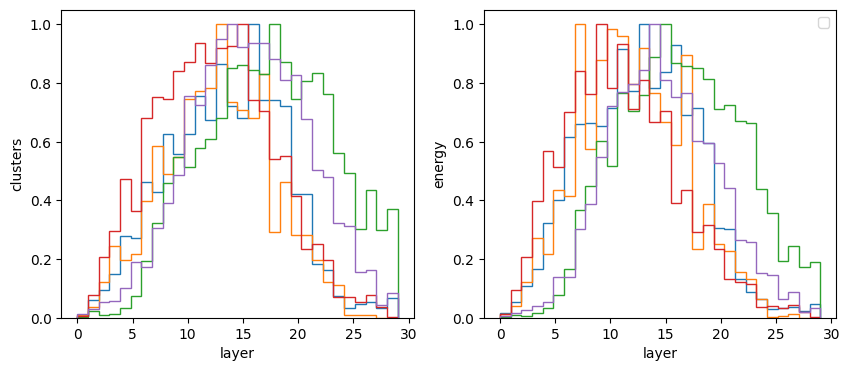

In [9]:

hist, (clusters_ax, energy_ax) = plt.subplots(1, 2, figsize=(10, 4))
start_event = 5
clusters = np.load(clusters_per_layer_path, mmap_mode='r')
energies = np.load(energy_per_layer_path, mmap_mode='r')
for i in range(start_event, start_event + 5):
    clu = clusters["rescaled_clusters_per_layer"][i]
    e = energies["rescaled_energy_per_layer"][i]
    clusters_ax.hist(np.arange(30), weights=clu, histtype='step', bins=30)
    energy_ax.hist(np.arange(30), weights=e, histtype='step', bins=30)
energy_ax.set_xlabel("layer")
clusters_ax.set_xlabel("layer")
energy_ax.set_ylabel("energy")
clusters_ax.set_ylabel("clusters")
energy_ax.legend()


In [10]:
# center of gravity 

cog_path, cog = showerflow_training.get_cog(
    configs, showerflow_dir, redo=False, local_batch_size=local_batch_size)

get_cog = showerflow_training.cog_from_kinematics
    

Using precaluclated cog


Found means [ 3.4938800e-01  1.8946569e+03 -4.9973221e+01], stds [ 0.5420669 12.471965   0.4638375]
[ 3.4938800e-01  1.8946569e+03 -4.9973221e+01] [ 0.5420669 12.471965   0.4638375]


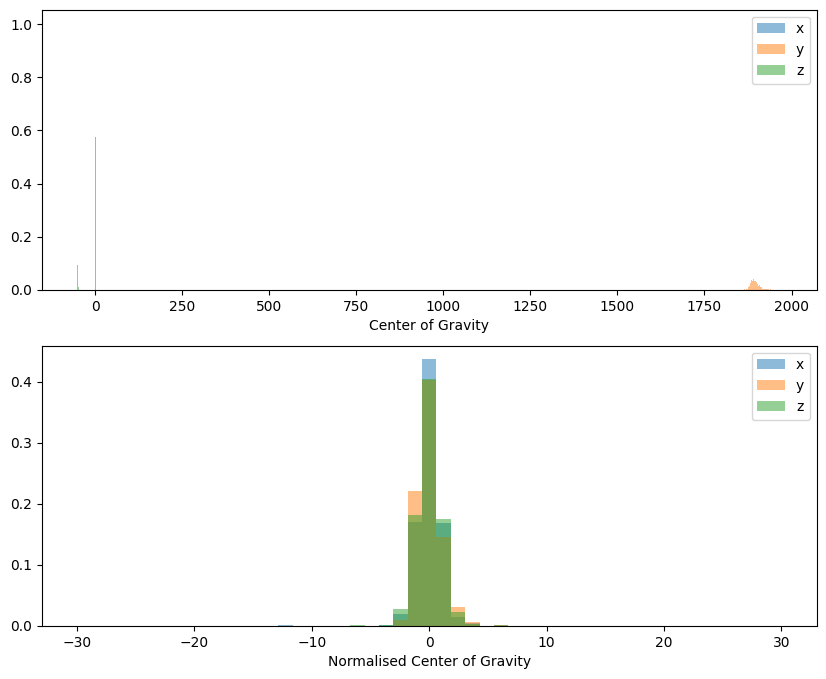

In [11]:
fig, (unnormed_ax, normed_ax) = plt.subplots(2, 1, figsize=(10,8))
kw_args = dict(bins = 50, alpha=0.5, density=True)
unnormed_ax.hist(cog[0], label='x', **kw_args)
unnormed_ax.hist(cog[1], label='y', **kw_args)
unnormed_ax.hist(cog[2], label='z', **kw_args)

unnormed_ax.set_xlabel("Center of Gravity")
unnormed_ax.legend()

normed_cog = np.copy(cog)
prenormed_mean = np.mean(normed_cog, axis=1)
prenormed_std = np.std(normed_cog, axis=1)
print(f"Found means {prenormed_mean}, stds {prenormed_std}")


normed_cog = (normed_cog - prenormed_mean[:, np.newaxis])/prenormed_std[:, np.newaxis]


cog_norm_path = os.path.join(showerflow_dir, "cog_norm")
np.savez(cog_norm_path, mean_cog=prenormed_mean, std_cog=prenormed_std)

kw_args["bins"] = np.linspace(-30, 30, 50)
normed_ax.hist(normed_cog[0], label='x', **kw_args)
normed_ax.hist(normed_cog[1], label='y', **kw_args)
normed_ax.hist(normed_cog[2], label='z', **kw_args)

normed_ax.set_xlabel("Normalised Center of Gravity")
normed_ax.legend()
print(prenormed_mean, prenormed_std)

## Training data

We now have everything needed to trian showerflow, we can add it to a pandas dataframe and run the training loop
As the dataset may be larger than can be carried in the ram, this will be repeated for each epoch.

In [12]:

make_train_ds = showerflow_training.train_ds_function_factory(
    pointsE_path, cog_path, clusters_per_layer_path, energy_per_layer_path, configs)

start_points = np.arange(0, n_events, local_batch_size)
# try it out
dataset = make_train_ds(0, 5)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)

Then we set where we intent to save the created model.

In [13]:
prefix = time.strftime("%y-%m-%d_cog_e_layer_")
outpath = os.path.join(showerflow_dir, prefix)
print(f"Saving to {outpath}")

best_model_path = os.path.join(showerflow_dir, "ShowerFlow_best.pth")
latest_model_path = os.path.join(showerflow_dir, "ShowerFlow_latest.pth")
best_data_path = os.path.join(showerflow_dir, "ShowerFlow_best_data.txt")

Saving to ../../point-cloud-diffusion-data/showerFlow/24-08-13_cog_e_layer_


In [14]:
# torch.manual_seed(123)

lr = 1e-5   # default: 5e-5
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

start_over = True
# epoch_load = 550
# model.load_state_dict(torch.load(outpath+f'ShowerFlow_{epoch_load}.pth')['model'])
# optimizer.load_state_dict(torch.load(outpath+f'ShowerFlow_{epoch_load}.pth')['optimizer'])
if os.path.exists(best_model_path) and not start_over:
    model.load_state_dict(torch.load(best_model_path)['model'])
    optimizer.load_state_dict(torch.load(best_model_path)['optimizer'])

    # load best_loss
    with open(best_data_path, 'r') as f:
        data = f.read().strip().split()
    best_loss = float(data[0])
    epoch_start = int(data[1])
else:
    best_loss = np.inf
    epoch_start = 1
print(f"A total of {params['epochs']} epochs are requested, the model had already undergone {epoch_start}")

A total of 20000 epochs are requested, the model had already undergone 1


The data is now all loaded, and ready to train on. If we had a previous best epoch it's loaded and we will start there.

In [15]:
model.train()

losses = []
batch_len = len(train_loader)
mean_loss = np.inf
total_epochs = params["epochs"]
for epoch in range(epoch_start, total_epochs):
    start_idx = start_points[epoch%len(start_points)]
    dataset = make_train_ds(start_idx, start_idx+local_batch_size)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)
    
    print(f"     Epoch number {epoch}; {(epoch-epoch_start)/(total_epochs-epoch_start):.0%} complete; mean loss {mean_loss:.2}", end='\r\r')
    loss_list = []
    for batch_idx, (energy, num_points, visible_energy, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer) in enumerate(train_loader):
        if batch_idx % 10 == 0:
            print(f"{batch_idx/batch_len:.0%}", end='\r')
            

        E_true = energy.view(-1, 1).to(device).float()
        num_points = num_points.view(-1, 1).to(device).float()
        energy_sum = visible_energy.view(-1,1).to(device).float()
        cog_x = cog_x.view(-1, 1).to(device).float()
        cog_y = cog_y.view(-1, 1).to(device).float()
        cog_z = cog_z.view(-1, 1).to(device).float()
        clusters_per_layer = clusters_per_layer.to(device).float()
        e_per_layer = e_per_layer.to(device).float()
   
        # normalise conditional labels
        E_true = (E_true/meta.incident_rescale).float()

        input_data = torch.cat((num_points, energy_sum, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer), 1)   #### input data structure required for network with additional features in latent space (e.g. Esum)
        optimizer.zero_grad()
        # try to add context for conditioning by concatenating 
        context = E_true
        
        if np.any(np.isnan(input_data.clone().detach().cpu().numpy())) == True:
            print('Nans in the training data!')
            
        #### check if any of the weights are nans
        if torch.stack([torch.isnan(p).any() for p in model.parameters()]).any():
            print('Weights are nan!')
            # load recent model
            model.load_state_dict(torch.load(latest_model_path)['model'])
            optimizer = optim.Adam(model.parameters(), lr=lr)
            #optimizer.load_state_dict(torch.load(outpath+f'ShowerFlow_latest.pth')['optimizer'])
            # print(f'model from {epoch-3} epoch reloaded')
            print(f'latest model reloaded, optimizer resetted')
                           
        nll = -distribution.condition(context).log_prob(input_data)
        loss = nll.mean()
        loss.backward()
        optimizer.step() 
        distribution.clear_cache()
        loss_list.append(loss.item())
    mean_loss = np.mean(loss_list)
    losses.append(mean_loss)

    if torch.stack([torch.isnan(p).any() for p in model.parameters()]).any(): # save models only if no nan weights
        print('model not saved due to nan weights')
    else:
        torch.save(
            {'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),},
            latest_model_path
        )

        # save best model based on loss
        if mean_loss <= best_loss:
            best_loss = mean_loss
            torch.save(
                {'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),},
                best_model_path
            )
            # save best loss value to txt file
            with open(best_data_path, 'w') as f:
                f.write(f"{best_loss} {epoch}")
        



## After training

Now the training is complete, there should be a best checkpoint. We will load this in order to generate some evaluation plots. Setting the seed makes sure the evaluation plots are reproducable.

In [16]:
# load best checkpoint
model.load_state_dict(torch.load(best_model_path)['model'])
optimizer.load_state_dict(torch.load(best_model_path)['optimizer'])

model.eval()
print('model loaded')

model loaded


In [17]:
# generate 
torch.manual_seed(123)

E_true_list = []
samples_list = []
num_points_list = []
visible_energy_list = []
cog_x_list = []
cog_y_list = []
cog_z_list = []
clusters_per_layer_list = []
e_per_layer_list = []
for batch_idx, (energy, num_points, visible_energy, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer) in enumerate(tqdm(train_loader)):
    E_true = energy.view(-1, 1).to(device).float()
    E_true = (E_true/100).float()
    with torch.no_grad():
        samples = distribution.condition(E_true).sample(torch.Size([E_true.shape[0], ])).cpu().numpy()
    E_true_list.append(E_true.cpu().numpy())
    samples_list.append(samples)
    num_points_list.append(num_points.cpu().numpy())
    visible_energy_list.append(visible_energy.cpu().numpy())
    cog_x_list.append(cog_x.cpu().numpy())  
    cog_y_list.append(cog_y.cpu().numpy())
    cog_z_list.append(cog_z.cpu().numpy())
    clusters_per_layer_list.append(clusters_per_layer.cpu().numpy())
    e_per_layer_list.append(e_per_layer.cpu().numpy())

raw_E_true = np.concatenate(E_true_list, axis=0)
samples = np.concatenate(samples_list, axis=0)
raw_num_points = np.concatenate(num_points_list, axis=0)
raw_visible_energy = np.concatenate(visible_energy_list, axis=0)
raw_cog_x = np.concatenate(cog_x_list, axis=0)
raw_cog_y = np.concatenate(cog_y_list, axis=0)
raw_cog_z = np.concatenate(cog_z_list, axis=0)
raw_clusters_per_layer = np.concatenate(clusters_per_layer_list, axis=0)
raw_e_per_layer = np.concatenate(e_per_layer_list, axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


In [18]:
samples.shape, raw_E_true.shape

((1000, 65), (1000, 1))

In [19]:
# sampled 
num_points_sampled = samples[:, 0] * meta.n_pts_rescale
visible_energy_sampled = samples[:, 1] * meta.vis_eng_rescale
cog_x_sampled = (samples[:, 2] * meta.std_cog[0]) + meta.mean_cog[0]
cog_y_sampled = (samples[:, 3] * meta.std_cog[1]) + meta.mean_cog[1]
cog_z_sampled = (samples[:, 4] * meta.std_cog[2]) + meta.mean_cog[2]
clusters_per_layer_sampled = samples[:, 5:35]
e_per_layer_sampled = samples[:, 35:]

# truth; we need to undo the shifts that were done in the last training batch

E_true = raw_E_true * meta.incident_rescale
num_points = raw_num_points * meta.n_pts_rescale
visible_energy = raw_visible_energy * meta.vis_eng_rescale
cog_x = (raw_cog_x * meta.std_cog[0]) + meta.mean_cog[0]
cog_y = (raw_cog_y * meta.std_cog[1]) + meta.mean_cog[1]
cog_z = (raw_cog_z * meta.std_cog[2]) + meta.mean_cog[2]


# clip cluster and energies per layer to [0,1]
clusters_per_layer_sampled = np.clip(clusters_per_layer_sampled, 0, 1)
e_per_layer_sampled = np.clip(e_per_layer_sampled, 0, 1)

In [20]:
print(cog_x.min(), cog_x.max())
print(cog_y.min(), cog_y.max())
print(cog_z.min(), cog_z.max())
meta.vis_eng_rescale

-2.2244350910186768 2.5555472373962402
1868.0804443359375 1968.2423095703125
-51.79668426513672 -47.87248229980469


array(2.5)

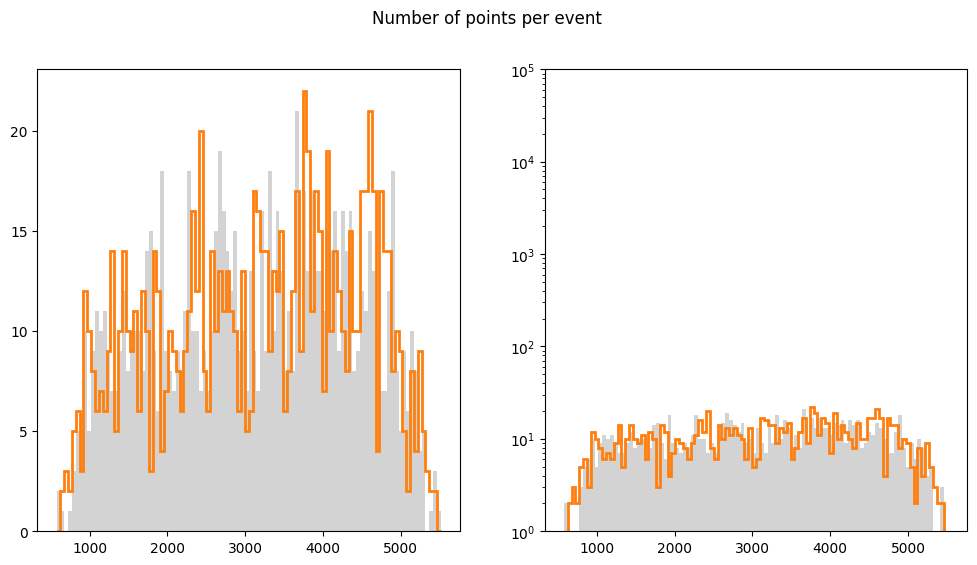

In [21]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(num_points.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(num_points_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(num_points.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(num_points_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e5)

plt.suptitle('Number of points per event')
plt.show()

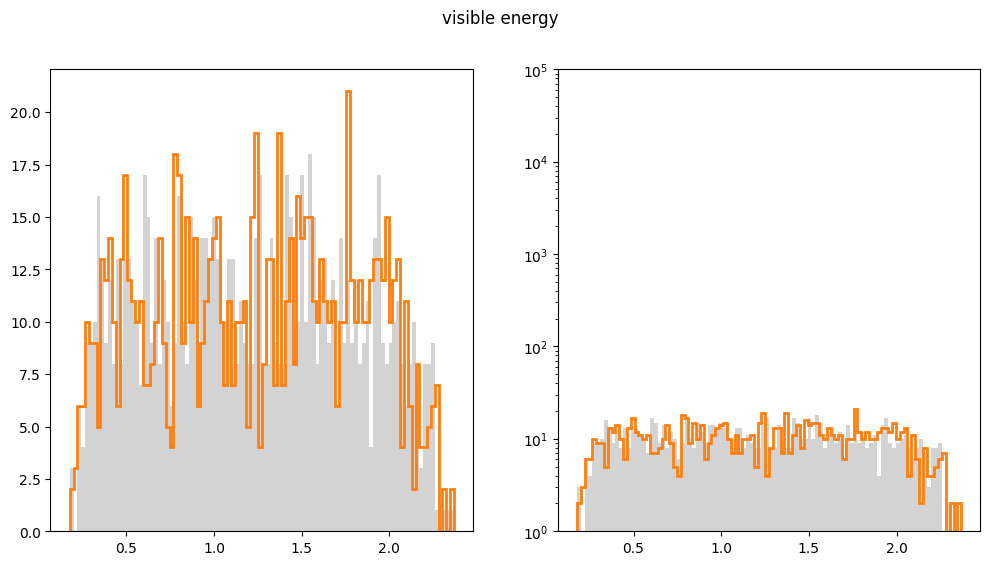

In [22]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(visible_energy.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(visible_energy_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(visible_energy.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(visible_energy_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e5)

plt.suptitle('visible energy')
plt.show()

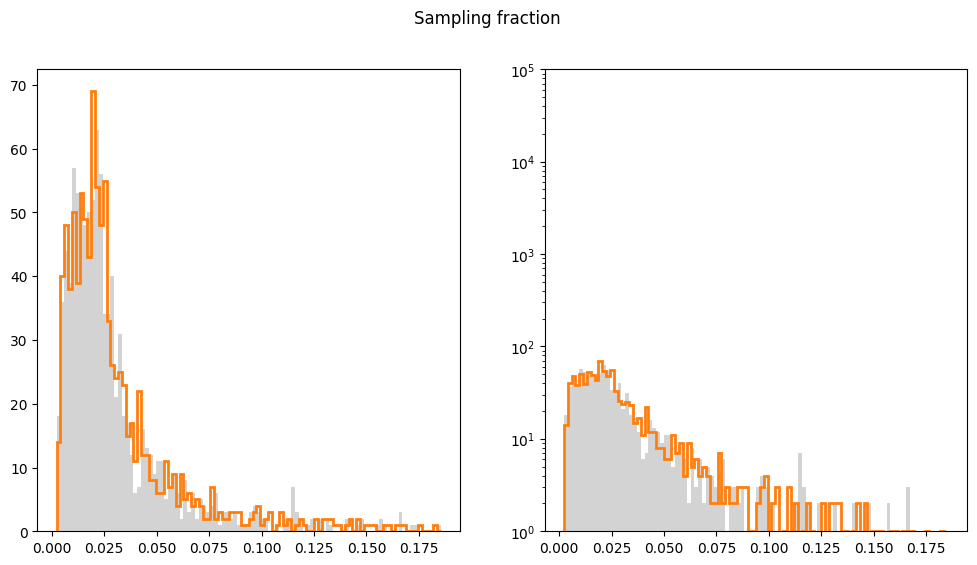

In [23]:
# sampling fraction
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(visible_energy.flatten()/E_true.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(visible_energy_sampled.flatten()/E_true.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(visible_energy.flatten()/E_true.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(visible_energy_sampled.flatten()/E_true.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e5)

# title over all subplots
fig.suptitle('Sampling fraction')
plt.show()

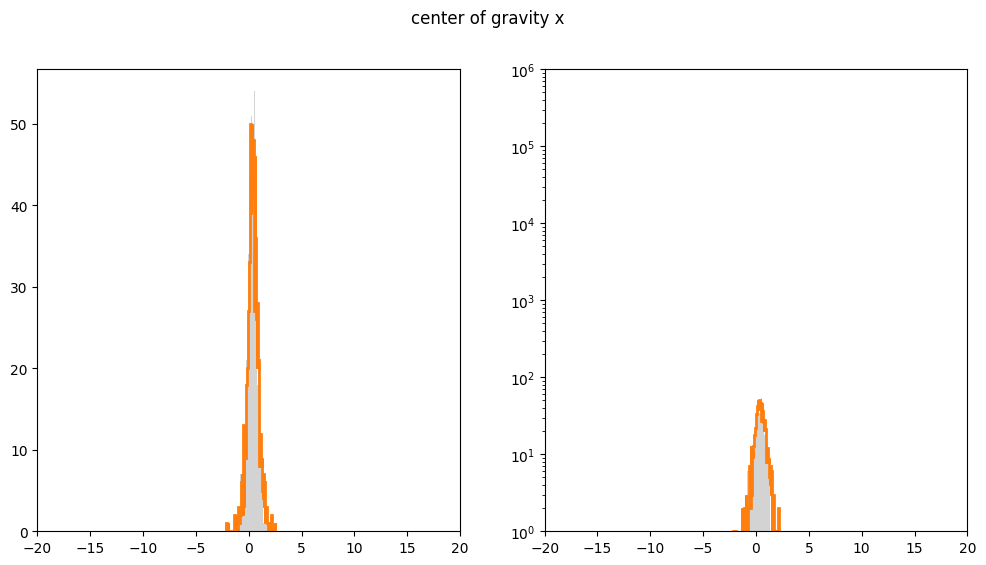

In [24]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(cog_x.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_x_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.xlim(-20,20)

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(cog_x.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_x_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
plt.ylim(1, 1e6)
plt.xlim(-20,20)

plt.suptitle('center of gravity x')
plt.show()

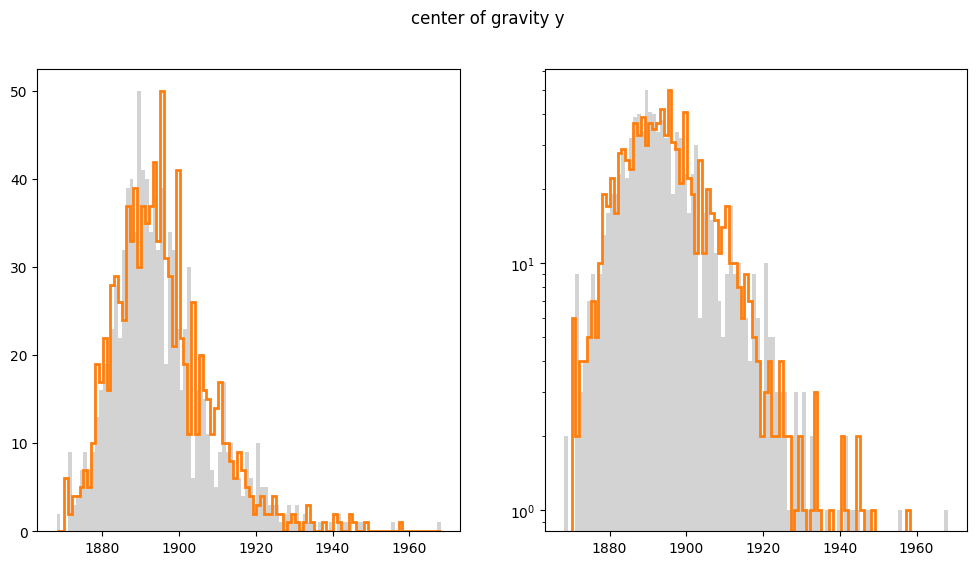

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

h = ax1.hist(cog_y.flatten(), bins=100, color='lightgrey')
h2 = ax1.hist(cog_y_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
#ax1.xlim(5,30)

# same but in log scale
h = ax2.hist(cog_y.flatten(), bins=100, color='lightgrey')
h2 = ax2.hist(cog_y_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
#plt.ylim(1, 1e6)
#plt.xlim(5,30)

plt.suptitle('center of gravity y')
plt.show()

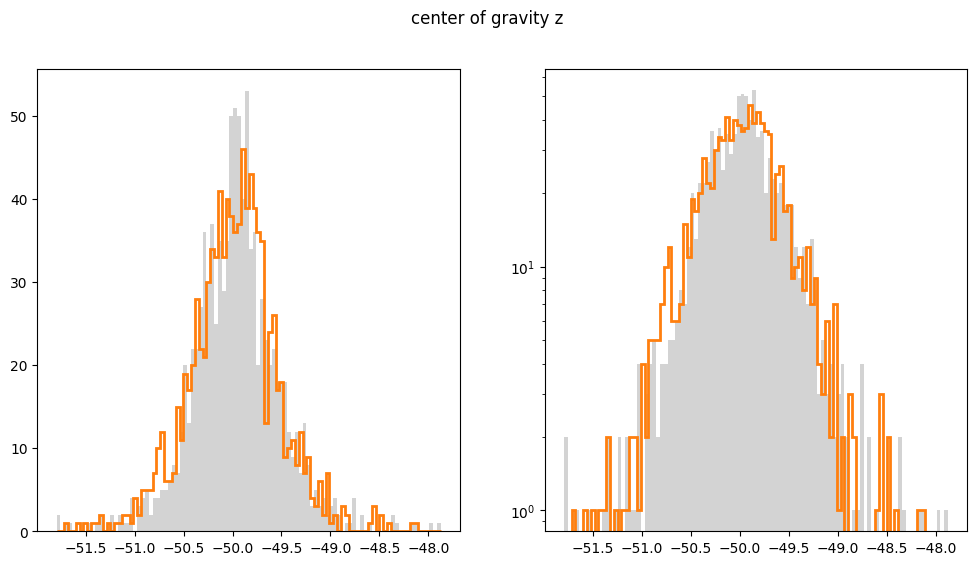

In [26]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
h = plt.hist(cog_z.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_z_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
#plt.xlim(25,60)

# same but in log scale
ax = fig.add_subplot(gs[1])
h = plt.hist(cog_z.flatten(), bins=100, color='lightgrey')
h2 = plt.hist(cog_z_sampled.flatten(), bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.yscale('log')
#plt.ylim(1, 1e6)
#plt.xlim(25,60)

plt.suptitle('center of gravity z')
plt.show()

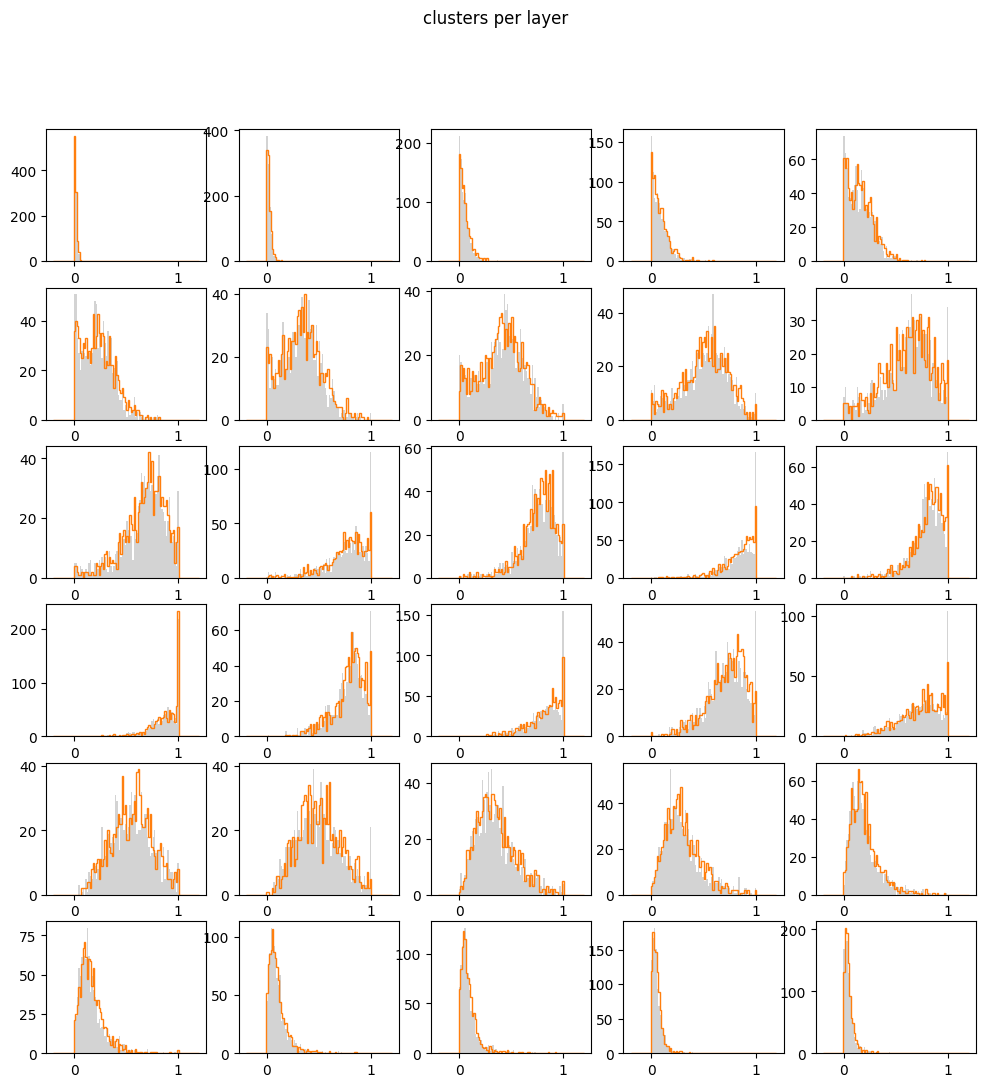

In [27]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6,5)

for i in range(30):
    fig.add_subplot(gs[i])
    h = plt.hist(clusters_per_layer[:,i].flatten(), bins=100, color='lightgrey', range=[-0.2,1.2])
    h2 = plt.hist(clusters_per_layer_sampled[:,i].flatten(), bins=h[1], histtype='step', lw=1, color='tab:orange')

plt.suptitle('clusters per layer')
plt.show()

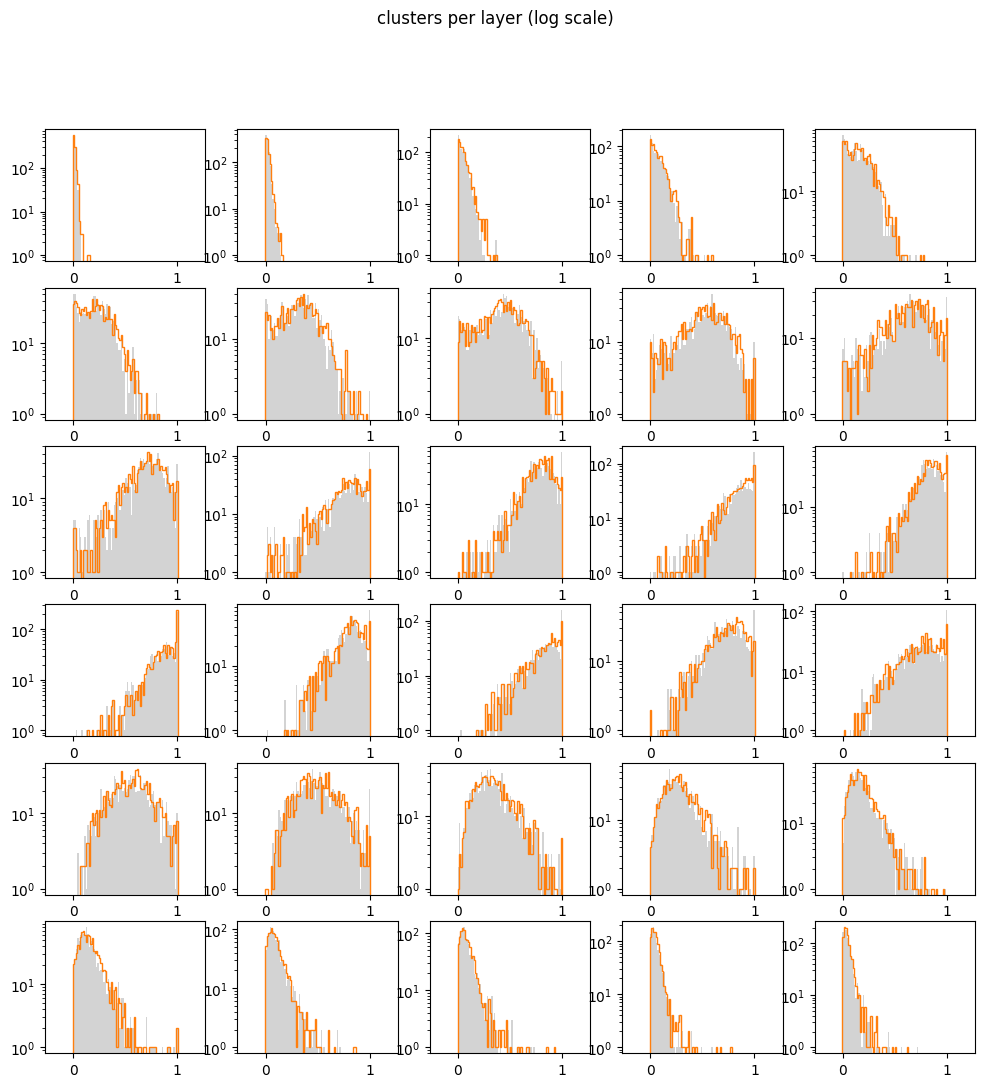

In [28]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6,5)

for i in range(30):
    fig.add_subplot(gs[i])
    h = plt.hist(clusters_per_layer[:,i].flatten(), bins=100, color='lightgrey', range=[-0.2,1.2])
    h2 = plt.hist(clusters_per_layer_sampled[:,i].flatten(), bins=h[1], histtype='step', lw=1, color='tab:orange')
    plt.yscale('log')

plt.suptitle('clusters per layer (log scale)')
plt.show()

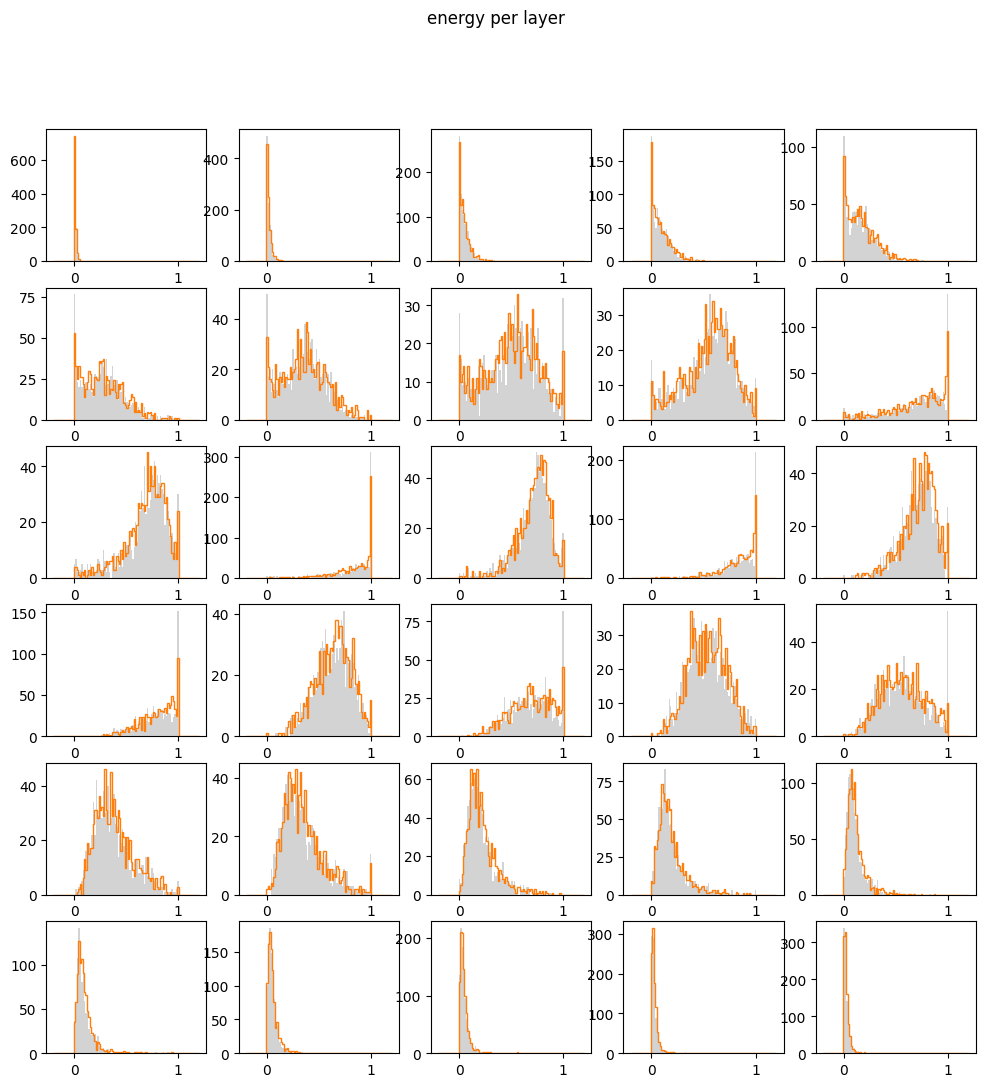

In [29]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6,5)

for i in range(30):
    fig.add_subplot(gs[i])
    h = plt.hist(e_per_layer[:,i].flatten(), bins=100, color='lightgrey', range=[-0.2,1.2])
    h2 = plt.hist(e_per_layer_sampled[:,i].flatten(), bins=h[1], histtype='step', lw=1, color='tab:orange')
    # plt.yscale('log')

plt.suptitle('energy per layer')
plt.show()

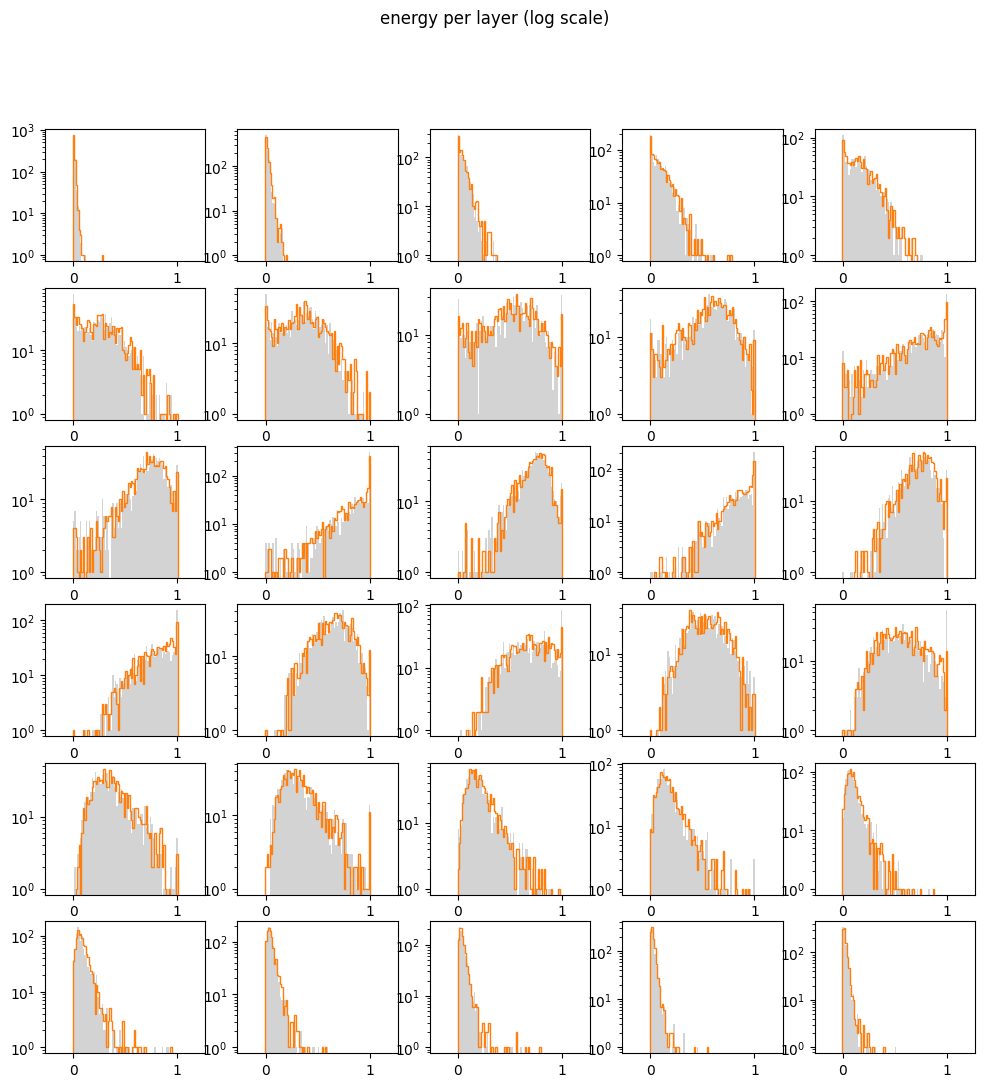

In [30]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6,5)

for i in range(30):
    fig.add_subplot(gs[i])
    h = plt.hist(e_per_layer[:,i].flatten(), bins=100, color='lightgrey', range=[-0.2,1.2])
    h2 = plt.hist(e_per_layer_sampled[:,i].flatten(), bins=h[1], histtype='step', lw=1, color='tab:orange')
    plt.yscale('log')

plt.suptitle('energy per layer (log scale)')
plt.show()